# Run & display stats

In [1]:
import gc
import os
import datetime
import numpy as np
from tqdm.notebook import tqdm
import math

from utils import merge_sim
from sim import FunctionType, Simulation, StaticSimulation, SimulationResults, LinearSimulation, LinearSimulationStatic, LongstepSimulation, LongstepSimulationStatic, SimulationEnsemble
from graph import GraphType, CompleteGraph, RingGraph, RingGraphWithSubgraph, RocGraph, ErGraph, CompleteGraph, TwoCityGraph
from rw_utils import pickle_obj
from db import SimulationDatabase, SimulationDirectory
import uuid

In [4]:
num_nodes = 200
nums_edges = [ 300, 600, 800, 850] # Для сравнения скорости в зависимости от значения p
# nums_edges = [ 300, 400, 500, 600, 700, 750, 800, 850, 900, 1000, 1050, 1100] # Для сравнения скорости в зависимости от количества ребер
graph_types = [ 
	GraphType.ring_subgraph,
	GraphType.two_city, 
] 
fractions = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]

num_runs_times = 2
num_runs = 10

params = [
	[
		{
			GraphType.ring_subgraph: {
				'graph': None,
				'eps': 0,
				'beta_0': 0.9999, # 0.055,
				'beta_1': 1, # 0.040,
				'alpha_0': 0.0001,
				'alpha_1': 0.0,
				'X': np.array([[0.035, .8], [0.035, .8]]), # RINGS
				'max_num_iter': 150_000,
				'end_condition': 1,
			},
			GraphType.two_city: {
				'graph': None,
				'eps': 0,
				'beta_0': 0.9999, # 0.055,
				'beta_1': 1, # 0.040,
				'alpha_0': 0.0001,
				'alpha_1': 0.0,
				'X': np.array([[0.035, .8], [0.035, .8]]), # CITIES
				'max_num_iter': 150_000,
				'end_condition': 1,
			}
		}
		for _ in range(len(nums_edges))
	]
]


graphs = []
for _ in params:
	graph = {}
	for edges in nums_edges:
		for graph_type in graph_types:
			for shift, fraction in enumerate(fractions): 
				if (graph_type == GraphType.two_city and fraction > 0.5):
					continue
				
				if (graph_type == GraphType.ring_subgraph):
					graph[(graph_type, edges + shift)] = (RingGraphWithSubgraph, {
						'num_nodes': num_nodes, 
						'additional_edges': edges - num_nodes, 
						'subgraph_edge_fraction': fraction,
						'random_nodes_position': True,
						'num_nodes_subgraph': None,
					})
				if (graph_type == GraphType.two_city):
					graph[(graph_type, edges + shift)] = (TwoCityGraph, {
						'num_nodes': num_nodes,
						'additional_edges': edges - num_nodes,
						'subgraph_edge_fraction': fraction,
						'num_shared_edges': 1,
						'num_nodes_subgraph': None,
					})
	graphs.append(graph)


[print(graph) for graph in graphs[0]]



# (FunctionType, static): Simulation
simulations = {
    (FunctionType.longstep, False): LongstepSimulation,
}

(<GraphType.ring_subgraph: 'ring_subgraph'>, 300)
(<GraphType.ring_subgraph: 'ring_subgraph'>, 301)
(<GraphType.ring_subgraph: 'ring_subgraph'>, 302)
(<GraphType.ring_subgraph: 'ring_subgraph'>, 303)
(<GraphType.ring_subgraph: 'ring_subgraph'>, 304)
(<GraphType.ring_subgraph: 'ring_subgraph'>, 305)
(<GraphType.ring_subgraph: 'ring_subgraph'>, 306)
(<GraphType.ring_subgraph: 'ring_subgraph'>, 307)
(<GraphType.ring_subgraph: 'ring_subgraph'>, 308)
(<GraphType.ring_subgraph: 'ring_subgraph'>, 309)
(<GraphType.ring_subgraph: 'ring_subgraph'>, 310)
(<GraphType.ring_subgraph: 'ring_subgraph'>, 311)
(<GraphType.ring_subgraph: 'ring_subgraph'>, 312)
(<GraphType.ring_subgraph: 'ring_subgraph'>, 313)
(<GraphType.ring_subgraph: 'ring_subgraph'>, 314)
(<GraphType.two_city: 'two_city'>, 300)
(<GraphType.two_city: 'two_city'>, 301)
(<GraphType.two_city: 'two_city'>, 302)
(<GraphType.two_city: 'two_city'>, 303)
(<GraphType.two_city: 'two_city'>, 304)
(<GraphType.two_city: 'two_city'>, 305)
(<GraphTyp

## Run

Careful with parameters for `Longstep, RocGraph(4x25)` and `Longstep, RingGraph(100,24)`.

In [5]:
sim_id = uuid.uuid4()
for num_run in range(num_runs_times):
	print(f"\nRUN: {num_run + 1}\n")
	for ex in range(len(params)):
		print(f"\nEXPERIMENT: {ex + 1}\n")
		
		for (graph_type, num_edges), (graph_class, graph_params) in graphs[ex].items():
			
			# Тут захардкодил, да. Признаю, немного испоганил код, но тут уже было лень думать 🫠
			# Графы в словаре создавались с количеством ребер 300, 301, 302..., 400, 401, 402 и т.п., 
			# чтобы прога могла их различать, поэтому поставлено условие принадлежности отрезку между num_edges

			# Если количество ребер одно
			# ie = 0
			
			# Если количество ребер используется для определения зависимости времени от плотности
			if (num_edges - 40 <= 300 <= num_edges + 40):
				ie = 0 
			elif (num_edges - 40 <= 600 <= num_edges + 40):
				ie = 1
			elif (num_edges - 40 <= 800 <= num_edges + 40):
				ie = 2
			elif (num_edges - 40 <= 850 <= num_edges + 40):
				ie = 3

			# Если количекство ребер используется для определения зависимости времени от количества ребер
			# if (num_edges - 40 <= 300 <= num_edges + 40):
			# 	ie = 0
			# if (num_edges - 40 <= 400 <= num_edges + 40):
			# 	ie = 1
			# if (num_edges - 40 <= 500 <= num_edges + 40):
			# 	ie = 2
			# if (num_edges - 40 <= 600 <= num_edges + 40):
			# 	ie = 3
			# if (num_edges - 40 <= 700 <= num_edges + 40):
			# 	ie = 4
			# if (num_edges - 40 <= 750 <= num_edges + 40):
			# 	ie = 5
			# if (num_edges - 40 <= 800 <= num_edges + 40):
			# 	ie = 6
			# if (num_edges - 40 <= 850 <= num_edges + 40):
			# 	ie = 7
			# if (num_edges - 40 <= 900 <= num_edges + 40):
			# 	ie = 8
			# if (num_edges - 40 <= 1000 <= num_edges + 40):
			# 	ie = 9
			# if (num_edges - 70 <= 1050 <= num_edges + 70):
			# 	ie = 10
			# if (num_edges - 70 <= 1100 <= num_edges + 70):
			# 	ie = 11
			
			# print(params[ex][ie][graph_type])
			simulations_ids = f"run{num_run}_____{sim_id}\\exp{ex}\\e{nums_edges[ie]}\\{graph_type}"
			
			for (func_type, static), simulation_class in simulations.items():
				params[ex][ie][graph_type]['graph'] = graph_class(**graph_params)
				
				sim = simulation_class(**params[ex][ie][graph_type])
				sim_ensemble = SimulationEnsemble(sim, num_runs, simulations_ids)
				sim_ensemble.run()


RUN: 1


EXPERIMENT: 1



LongstepSimulation on ring_subgraph(n=200,g=100,p=0.1,pos=random) (300 edges): 100%|██████████| 10/10 [00:00<00:00, 37.64it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.15,pos=random) (300 edges): 100%|██████████| 10/10 [00:00<00:00, 42.90it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.2,pos=random) (300 edges): 100%|██████████| 10/10 [00:00<00:00, 51.01it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.25,pos=random) (300 edges): 100%|██████████| 10/10 [00:00<00:00, 44.71it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.3,pos=random) (300 edges): 100%|██████████| 10/10 [00:00<00:00, 40.11it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.35,pos=random) (300 edges): 100%|██████████| 10/10 [00:00<00:00, 57.72it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.4,pos=random) (300 edges): 100%|██████████| 10/10 [00:00<00:00, 46.70it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.45,pos=random) (300 edges): 100%|██████████| 10/10 [00:0


RUN: 2


EXPERIMENT: 1



LongstepSimulation on ring_subgraph(n=200,g=100,p=0.1,pos=random) (300 edges): 100%|██████████| 10/10 [00:00<00:00, 37.40it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.15,pos=random) (300 edges): 100%|██████████| 10/10 [00:00<00:00, 60.08it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.2,pos=random) (300 edges): 100%|██████████| 10/10 [00:00<00:00, 46.29it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.25,pos=random) (300 edges): 100%|██████████| 10/10 [00:00<00:00, 42.34it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.3,pos=random) (300 edges): 100%|██████████| 10/10 [00:00<00:00, 41.75it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.35,pos=random) (300 edges): 100%|██████████| 10/10 [00:00<00:00, 52.94it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.4,pos=random) (300 edges): 100%|██████████| 10/10 [00:00<00:00, 69.86it/s]
LongstepSimulation on ring_subgraph(n=200,g=100,p=0.45,pos=random) (300 edges): 100%|██████████| 10/10 [00:0

## Display stats

In [ ]:

import scipy.stats as stats


simulation_id = 'run0_____3be1bada-f377-4d1a-bd55-6f8ef09b0b6d\\exp0\\e600\\ring_subgraph'
# path = os.path.join(f'output\\{simulation_id}\\linear', str(simulations_ids))
sdb = SimulationDatabase(path=f'output\\{simulation_id}\\')
for (graph_type, num_edges), (_, graph_params) in graphs[0].items():
	for (func_type, static), _ in simulations.items():
		sdirs = [
			sdir
			for sdir in sdb.sdirs
			if (sdir.sim.func_type == func_type) and
			(num_edges - 70 <= sdir.sim.graph.graph.number_of_edges() <= num_edges + 70) and
			(sdir.sim.graph.graph_type == graph_type)
		]
		
		num_sims = len(fractions) if graph_type == GraphType.ring_subgraph else math.ceil(len(fractions) / 2)
		# if len(sdirs) != num_sims:
		# 	raise RuntimeError(f"Found {len(sdirs)} SimulationDirectories after filter. Expected {num_sims}.")
		
		for sdir in sdirs:
			sdir.cache()
			sdir.info()
			del sdir
		gc.collect()


### Save stats

In [ ]:

import scipy.stats as stats
import pandas as pd

def segment_intersection(a1, a2, b1, b2):
    if a2 < b1:
        return '<'
    elif b2 < a1:
        return '>'
    else:
        return '='


dataframe = pd.DataFrame(columns=['num_edges', 'graph_type', '95% left', '95% right', 't_mean', 't_sem', 't_max', 'comparison'])
for edge in nums_edges:
	simulation_id = f'run0_____3be1bada-f377-4d1a-bd55-6f8ef09b0b6d\\exp0\\e600\\ring_subgraph'
	# path = os.path.join(f'output\\{simulation_id}\\linear', str(simulations_ids))
	sdb = SimulationDatabase(path=f'output\\{simulation_id}\\')
	cycle = {'graph': '', 'value':0}
	for (graph_type, num_edges), (_, graph_params) in graphs[0].items():
		# if not (num_edges - 40 <= 800 <= num_edges + 40):
		# 	continue
		if (cycle['graph'] == graph_type and cycle['value'] == 1):
			continue
		else: 
			cycle['graph'] = graph_type
			cycle['value'] = 0
		for (func_type, static), _ in simulations.items():
			
			print(graph_type, num_edges, func_type)
			sdirs = [
				sdir
				for sdir in sdb.sdirs
				# if (sdir.sim.func_type == func_type) and
				# (num_edges - 30 <= sdir.sim.graph.graph.number_of_edges() <= num_edges + 30) and
				# (sdir.sim.graph.graph_type == graph_type)
			]
			num_sims = len(fractions) if graph_type == GraphType.ring_subgraph else len([f for f in fractions if f <= 0.5])
			# if len(sdirs) != num_sims:
			# 	raise RuntimeError(f"Found {len(sdirs)} SimulationDirectories after filter. Expected {num_sims}.")
			for sdir in sdirs:
				sdir.cache()
				sdir.info()
				t_sem = stats.sem(sdir.times)
				interval = stats.norm.interval(confidence=0.95, loc=sdir.t_mean_1, scale=t_sem)
				
				do_count_intersection = dataframe[dataframe.columns[0]].count()
				
				if (do_count_intersection > 0): 
					last_data = dataframe.iloc[-1]
				new_data = [num_edges, 
								graph_type, 
								interval[0],  
								interval[1], 
								sdir.t_mean_1,
								t_sem, 
								sdir.t_max, 
								segment_intersection(
									interval[0], 
									interval[1],
									last_data['95% left'], 
									last_data['95% right']) 
									if do_count_intersection > 0 else '']
				dataframe.loc[len(dataframe)] = new_data
				
				del sdir
			cycle['value'] = 1
			gc.collect()
dataframe.to_excel("output_edges_dependency.xlsx")


# Plot & animate

In [6]:
import os
import gc
import numpy as np
from matplotlib import pyplot as plt

from sim import FunctionType, StaticSimulation, FunctionType
from graph import GraphType, RingGraph, RocGraph, ErGraph
from plot import SigmaPlot
from db import SimulationDatabase, SimulationDirectory
from utils import sigma_mean, sigmas, pad
from rw_utils import read_pickled, deserialize_boolean_array
from animate import animate

%matplotlib inline

In [7]:
color = {
    # GraphType.ring: 'red',
    # GraphType.roc: 'green',
    # GraphType.er: 'blue',
    # GraphType.ring_subgraph: ['red', 'orange', 'yellow', 'green', 'cyan', 'lightblue', 'blue', 'purple', 'magenta', 'grey'],
    GraphType.ring_subgraph: [
      	'#ff0000', #ff6666
		'#ff5901',
		'#ffb202', #ffd167
		'#f4ff03',
		'#9dff04', #c4ff68
		'#47ff05',
		'#06ff1c',
		'#07ff73',
		'#09ffc9', #6bffdf
		'#0adfff',
		'#0b8bff',
		'#0c37ff',
		'#360dff',
		'#8b0eff',
		'#df0fff',

	],
    GraphType.two_city: [
      	'#ff0000',
		'#ff5901',
		'#ffb202',
		'#f4ff03',
		'#9dff04',
		'#47ff05',
		'#06ff1c',
		'#07ff73',
		'#09ffc9',
		'#0adfff',
		'#0b8bff',
		'#0c37ff',
		'#360dff',
		'#8b0eff',
		'#df0fff',
	],
}

x_right = {
    FunctionType.linear: 2000,
    FunctionType.longstep: 8000 # 2000, 5000, 8000, 15000, 30000
}

label = {
    GraphType.ring_subgraph: 'Кольцо с подграфом',
    GraphType.two_city: 'Два города',
}

## Plot all

### Merge all simulations

In [9]:
from utils import merge_sim
from graph import GraphType

merge_exp = [0]
merge_edge = [300, 600, 800, 850]
merge_graph_type = [GraphType.ring_subgraph, GraphType.two_city]

for exp in merge_exp:
  for edge in merge_edge:
    for graph_type in merge_graph_type:
      search_sim = f"exp{exp}\\e{edge}\\{graph_type}"
      print(f"SEARCHING FOR: {search_sim}")
      merge_sim(["output"], search_sim, "output\\merged")


SEARCHING FOR: exp0\e300\ring_subgraph
['exp0', 'e300']
output\merged\merge\exp0
output\merged\merge\exp0\e300
SEARCHING FOR: exp0\e300\two_city
['exp0', 'e300']
SEARCHING FOR: exp0\e600\ring_subgraph
['exp0', 'e600']
output\merged\merge\exp0\e600
SEARCHING FOR: exp0\e600\two_city
['exp0', 'e600']
SEARCHING FOR: exp0\e800\ring_subgraph
['exp0', 'e800']
output\merged\merge\exp0\e800
SEARCHING FOR: exp0\e800\two_city
['exp0', 'e800']
SEARCHING FOR: exp0\e850\ring_subgraph
['exp0', 'e850']
output\merged\merge\exp0\e850
SEARCHING FOR: exp0\e850\two_city
['exp0', 'e850']


### Plot

[SimulationDirectory_longstep_ring_subgraph_e300_run20, SimulationDirectory_longstep_ring_subgraph_e300_run20, SimulationDirectory_longstep_ring_subgraph_e300_run20, SimulationDirectory_longstep_ring_subgraph_e300_run20, SimulationDirectory_longstep_ring_subgraph_e300_run20, SimulationDirectory_longstep_ring_subgraph_e300_run20, SimulationDirectory_longstep_ring_subgraph_e300_run20, SimulationDirectory_longstep_ring_subgraph_e300_run20, SimulationDirectory_longstep_ring_subgraph_e300_run20, SimulationDirectory_longstep_ring_subgraph_e300_run20, SimulationDirectory_longstep_ring_subgraph_e300_run20, SimulationDirectory_longstep_ring_subgraph_e300_run20, SimulationDirectory_longstep_ring_subgraph_e300_run20, SimulationDirectory_longstep_ring_subgraph_e300_run20, SimulationDirectory_longstep_ring_subgraph_e300_run20]
caching SimulationDirectory for LongstepSimulation on ring_subgraph(n=200,g=100,p=0.1,pos=random), 300 edges (20 runs)...
caching SimulationDirectory for LongstepSimulation o

d:\Personal\University\sem8\ВКР\Код\Gevo\db.py:55: RuntimeWarning: Mean of empty slice.
  self.t_mean_0 = self.times[~self.outcomes].mean()
c:\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ring_subgraph_longstep_e850_t=1000.png:
ring_subgraph_longstep_e850_t=2000.png:
[SimulationDirectory_longstep_two_city_e300_run20, SimulationDirectory_longstep_two_city_e300_run20, SimulationDirectory_longstep_two_city_e300_run20, SimulationDirectory_longstep_two_city_e300_run20, SimulationDirectory_longstep_two_city_e300_run20, SimulationDirectory_longstep_two_city_e300_run20, SimulationDirectory_longstep_two_city_e300_run20, SimulationDirectory_longstep_two_city_e300_run20, SimulationDirectory_longstep_two_city_e300_run20]
caching SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=100,sh_e=1,p=0.1), 300 edges (20 runs)...
caching SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=100,sh_e=1,p=0.1), 300 edges (20 runs)...
caching SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=100,sh_e=1,p=0.1), 300 edges (20 runs)...
caching SimulationDirectory for LongstepSimulation on two_city(n=200,a_e=100,sh_e=1,p=0.1), 300 edges (20 runs)...
caching S

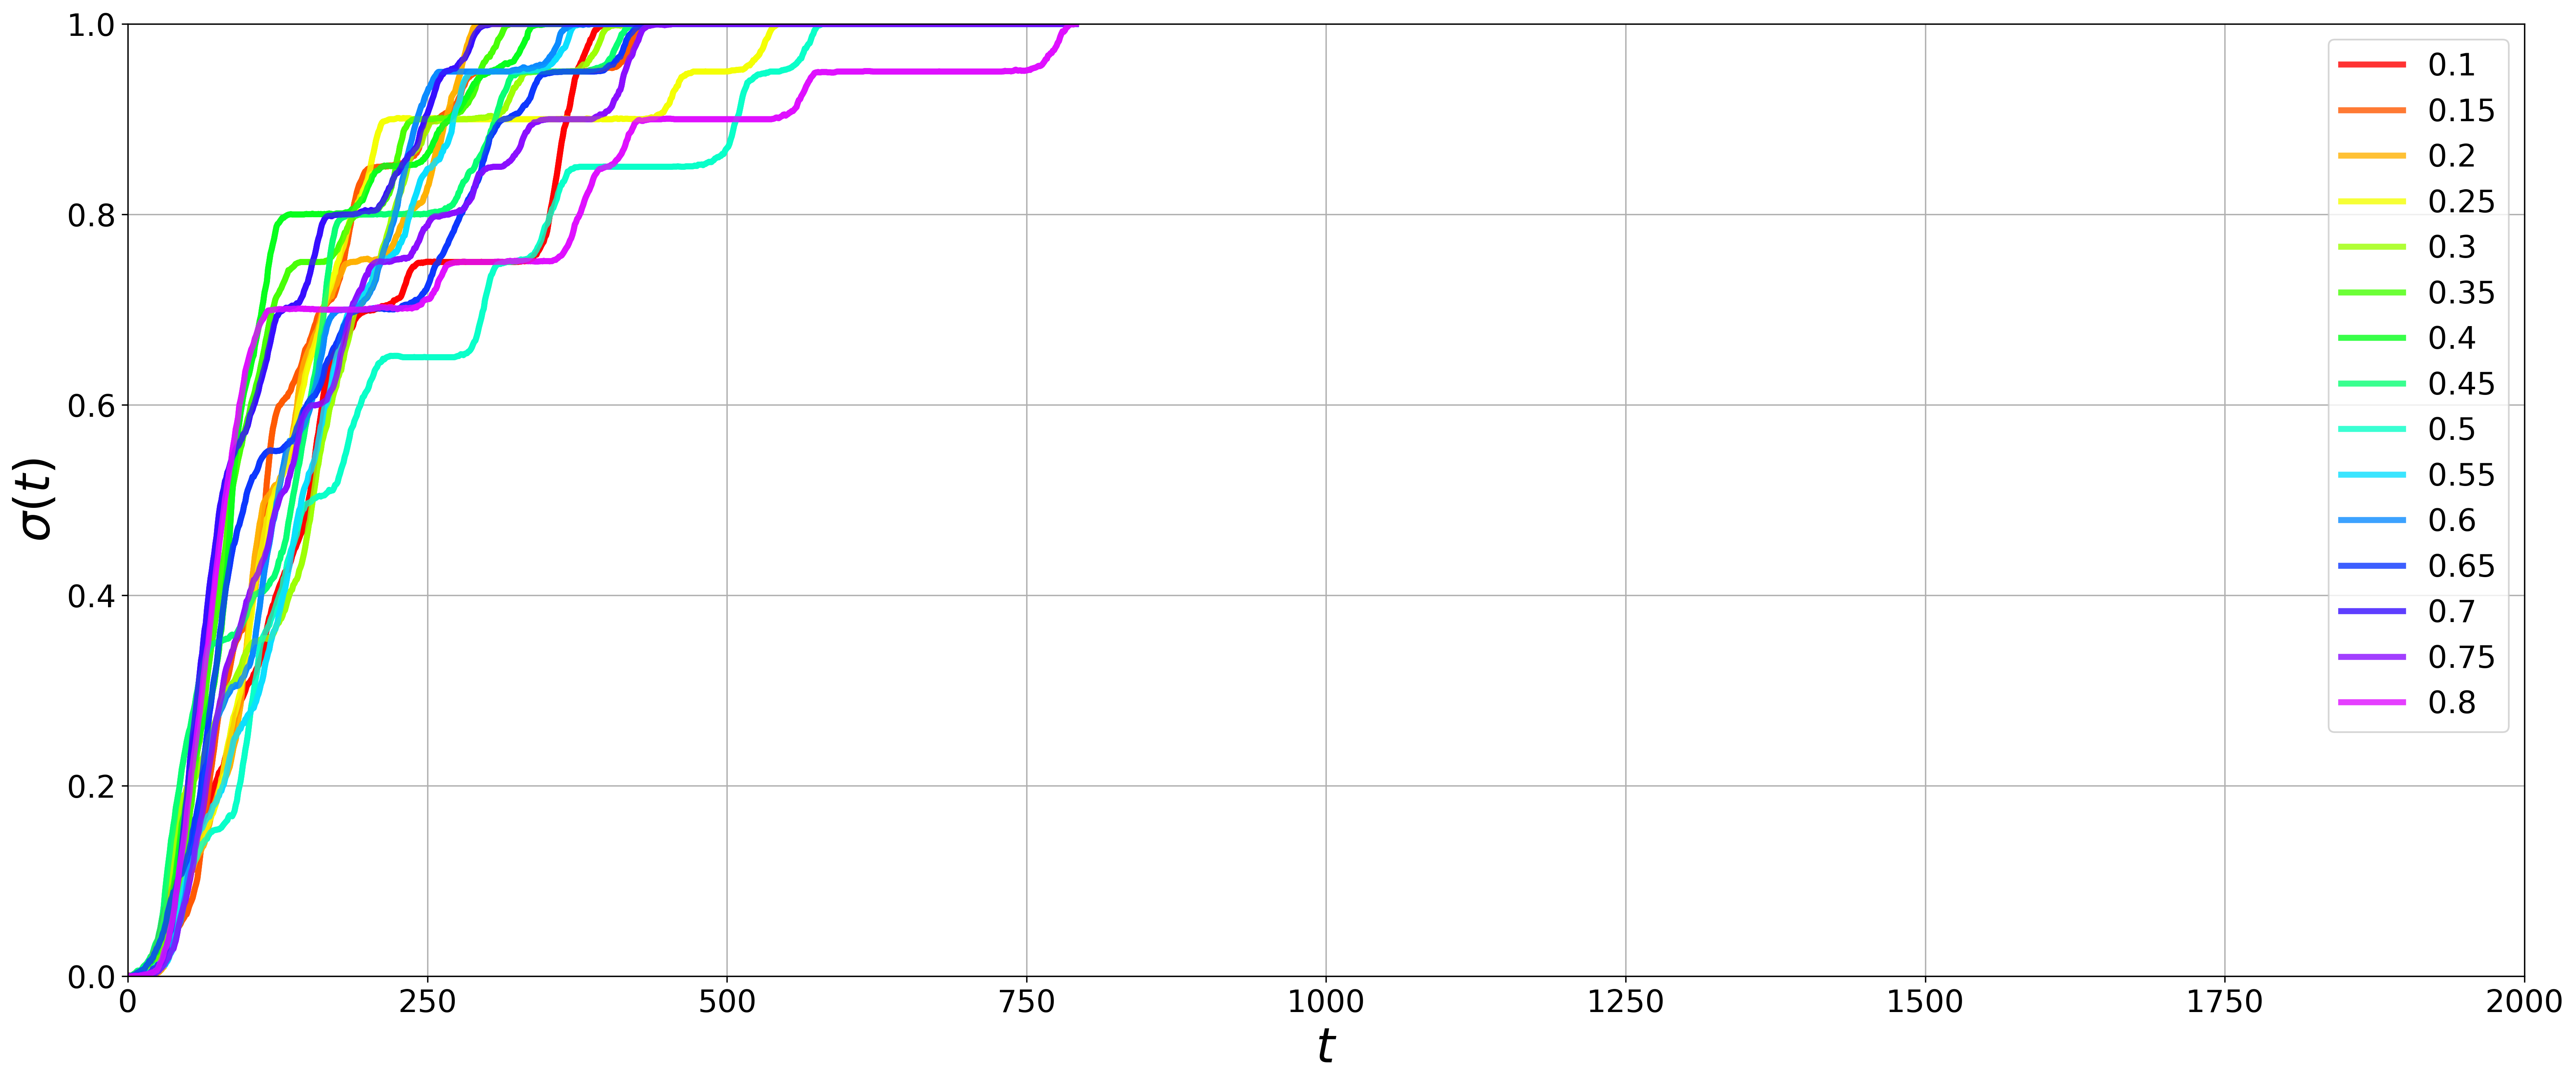

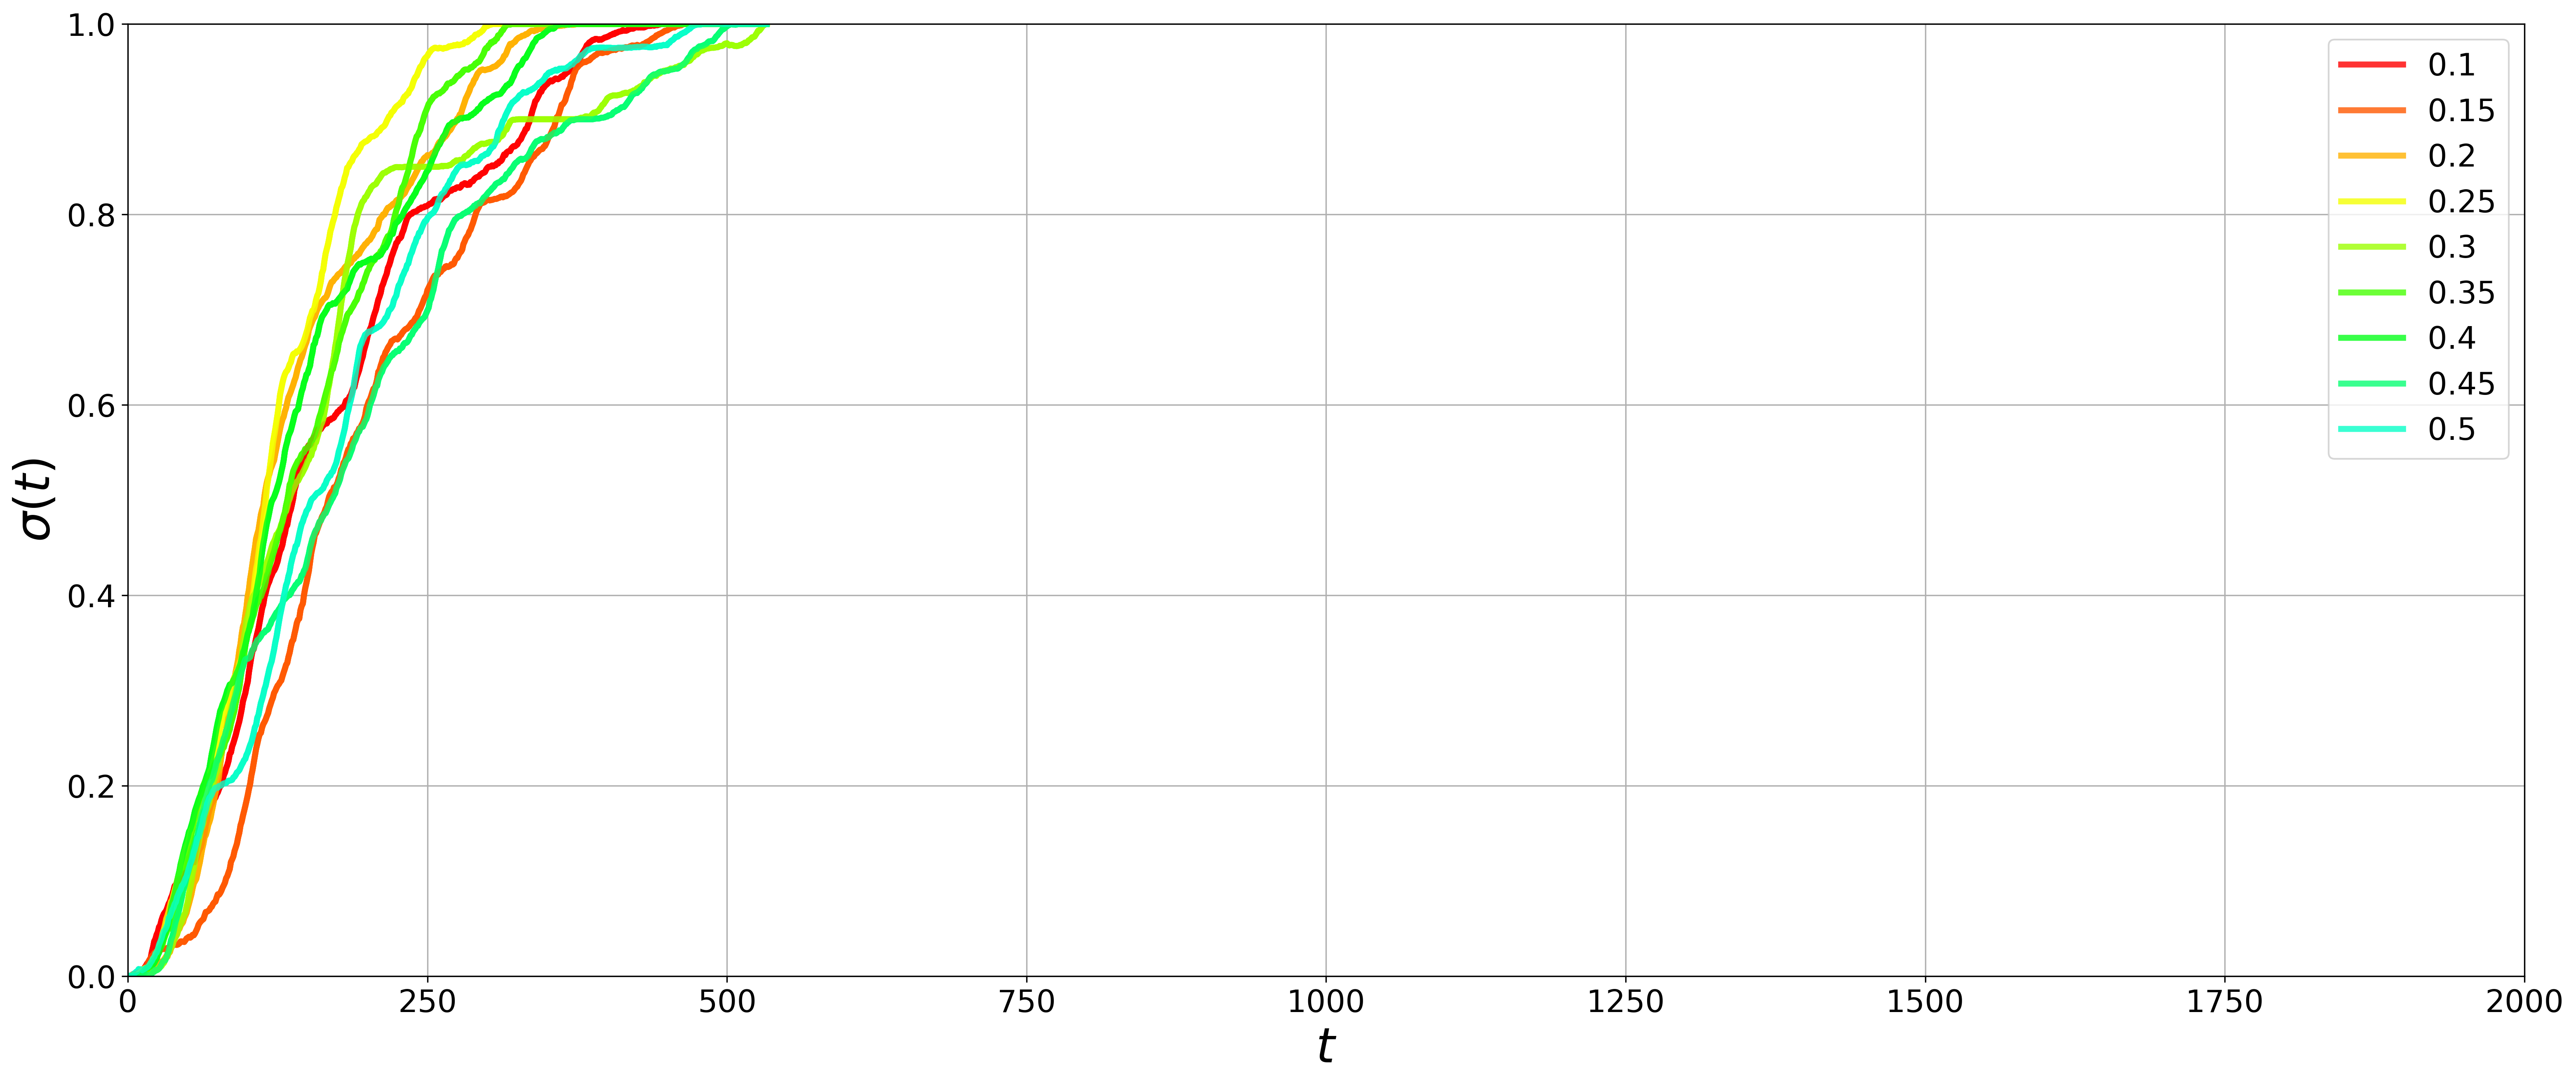

In [11]:
n_edges = 850
simulation_id = f'merged\\merge\\exp0\\e300\\'

statics = [
    False,
]

func_types = [
    FunctionType.longstep
]

sdb = SimulationDatabase(path=f'output\\{simulation_id}')

for func_type in func_types:
	type_legend = True
	for graph_type in graph_types:
		# if not (num_edges - 40 <= 800 <= num_edges + 40):
		# 	continue
		sdirs = [
			sdir
			for sdir in sdb.sdirs
			if (sdir.sim.func_type == func_type) and
			# (num_edges - 40 <= sdir.sim.graph.graph.number_of_edges() <= num_edges + 40) and
			(sdir.sim.graph.graph_type == graph_type) 
		]
		num_sims = len(fractions) if graph_type == GraphType.ring_subgraph else len([f for f in fractions if f <= 0.5])
		print(sdirs)
		if len(sdirs) != num_sims:
			raise RuntimeError(f"Expected {num_sims} SimulationDirectories after filter, got {len(sdirs)}.")


		sim = sdirs[0].sim
		
		splot = SigmaPlot(linewidth=3.5, alpha=.8, ax_tick_size=18, ax_label_size=28, figsize=(25, 10), display_legend=True)
		
		for sdir in sdirs:
			print(f'caching {sdir}...')
			sdir.cache()
		print()
		x_max = max([sdir.t_max for sdir in sdirs])


		''' 
		Нужно для отображения единичных симуляций. 
		Этот процесс не автоматизировал, поэтому приходится ручками менять
		''' 
		# sdir = None
		# if (graph_type == GraphType.two_city):
		# 	sdir = sdirs[2]	
		# 	sdir_color = '#ffd167'
		# else:
		# 	sdir_color = '#6bffdf'
		# 	sdir = sdirs[8]
		# sdir.cache()
		# for state in sdir.state_histories[:]:
		# 	sigma_avg = sigma_mean([state], pad_to=x_max)
			
		# 	splot.ax.plot(
		# 		range(len(sigma_avg)),
		# 		sigma_avg,
		# 		color=sdir_color, #ec5353 #d8ff9b #9dffe9
		# 		alpha=0.8,
		# 		linewidth=splot.linewidth,
		# 		ls=splot.linestyle,
		# 	)


		
		for _x_right in [500, 1000, 2000]:#, 3500, 5000, 8000, 16000, 30000, 100000, 160000]:
		# for _x_right in [8000]: # 8000, 30000, 100000
			for i, sdir in enumerate(sdirs):
				if (type_legend):
					splot.plot(sdir, color=color[sdir.sim.graph.graph_type][i], x_max=x_max, label=str(fractions[i]) )
				else:
					splot.plot(sdir, color=color[sdir.sim.graph.graph_type][i], x_max=x_max)
			type_legend = False
			
			xright = _x_right
			# xright = x_right[sim.func_type]
			splot.update_axlims(x_right=xright)
			# display
			# display(splot.fig)
			# fname = f"{sim.graph.graph_type}_{sim.func_type}_e{sim.graph.graph.number_of_edges()}_t={xright}" + ".png"
			fname = f"{sim.graph.graph_type}_{sim.func_type}_e{n_edges}_t={xright}" + ".png"
			print(f"{fname}:")
			# save
			splot.fig.savefig(
				os.path.join('plots', fname),
				bbox_inches='tight',
				pad_inches=0
			)
		type_legend = True
		gc.collect()




### Save

In [ ]:
splot.fig.savefig(
    os.path.join('plots', fname),
    bbox_inches='tight',
    pad_inches=0
)

## Animate

In [ ]:
sdir = SimulationDirectory(f"output\\run0_____063571c5-44f3-4ed7-bda0-d0e476340ce7\\exp0\\e1000\\ring_subgraph\\2024.05.14_02.29.42_longstep_ring_subgraph(n=200,g=100,p=0.8,pos=random)")
pickle_num = '05'
sr = read_pickled(pickle_num, path=sdir.path)
animate(
    sdir.sim,
    sr,
    filename=f'test_pickle{pickle_num}',
    path=sdir.path,
    t_start=0, # max(0, sr.t - 1000),
    t_end= 1000, # sr.t,
    overwrite=True
)